In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import scoobi
from scoobi.math_module import xp, _scipy, ensure_np_array
from scoobi.imshows import imshow1, imshow2, imshow3
import scoobi.scoobi as scoobi
import scoobi.utils as utils

import lina
print(scoobi.__file__)
print(lina.__file__)

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient

client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

def restart_clients():
    client0 = INDIClient('localhost', 7624)
    client0.start()

    client = IndiClient()
    client.connect()
    client.get_properties()

/opt/conda/envs/km310env/lib/python3.10/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


/home/kianmilani/Projects/scoob-interface/scoobi/scoobi.py
/home/kianmilani/Projects/lina/lina/__init__.py


In [2]:
scoobi.home_block(client0)

In [4]:
scoobi.move_block_out(client0)

In [3]:
reload(scoobi)
xc, yc = (4910, 3200)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [5]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')

# Do the normalization

In [13]:
scoobi.move_psf(-50, 0, client0)

In [7]:
reload(scoobi)
I.set_zwo_exp_time(0.000120, client0)

Set the ZWO exposure time to 1.20e-04s


In [8]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [9]:
reload(scoobi)
I.set_fib_atten(28, client)

Set the fiber attenuation to 28.0


28808


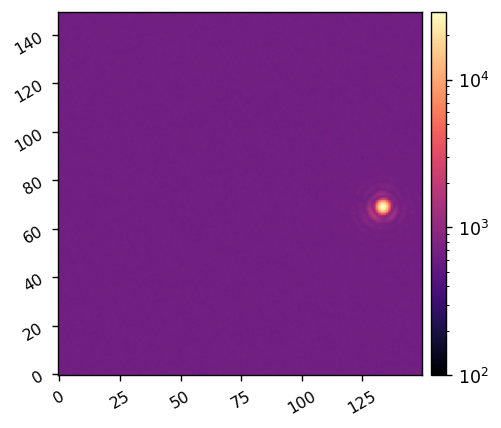

In [14]:
I.Nframes = 100
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [15]:
I.ref_psf_params = {
    'Imax': copy.copy(xp.max(ref_psf)),
    'texp': copy.copy(I.texp), 
    'atten': copy.copy(I.atten),
    'gain': copy.copy(I.gain),
}
utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)

Saved data to:  data/20241017_ref_psf_params.pkl


In [11]:
I.reset_dm()

In [36]:
scoobi.move_psf(2, 0, client0)

In [30]:
scoobi.move_psf(0, 1, client0)

In [37]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


In [38]:
I.set_zwo_exp_time(0.0003, client0)

Set the ZWO exposure time to 3.00e-04s


In [39]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


# Make a function to adjust bias on the camera
camsci.blacklevel.target

In [54]:
reload(scoobi)
scoobi.move_block_in(client0)

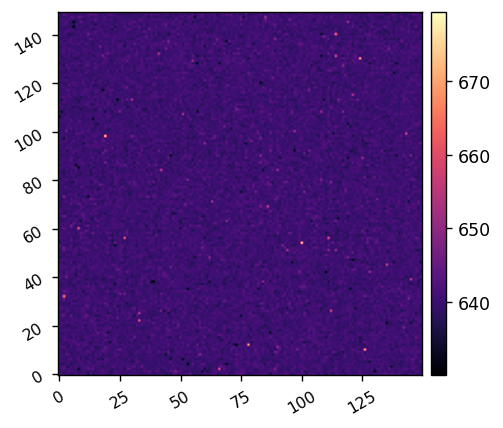

In [55]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()

I.df = copy.copy(dark_frame)
imshow1(dark_frame)

In [56]:
reload(scoobi)
scoobi.move_block_out(client0)

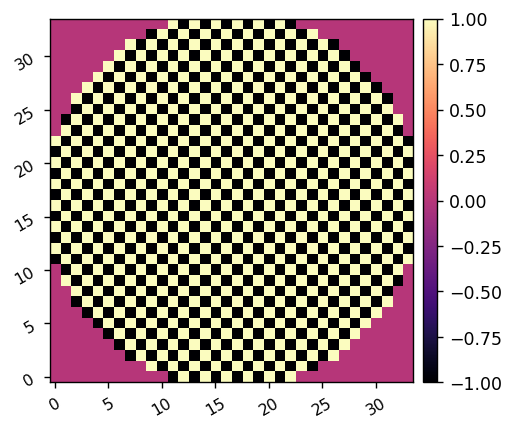

In [57]:
reload(scoobi.utils)
waffle_command = scoobi.utils.create_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

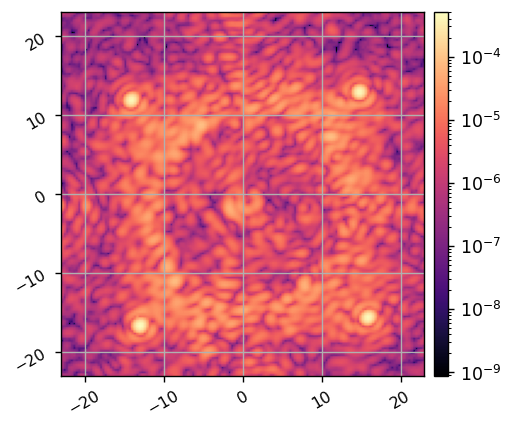

In [58]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

I.NSCICAM = 100
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamD, grid=True)

Centroids:
 [[ 32.13888671  20.37715297]
 [ 28.53836855 113.22043062]
 [122.57206722 116.56082212]
 [126.11001838  23.66966915]
 [ 32.13888671  20.37715297]]


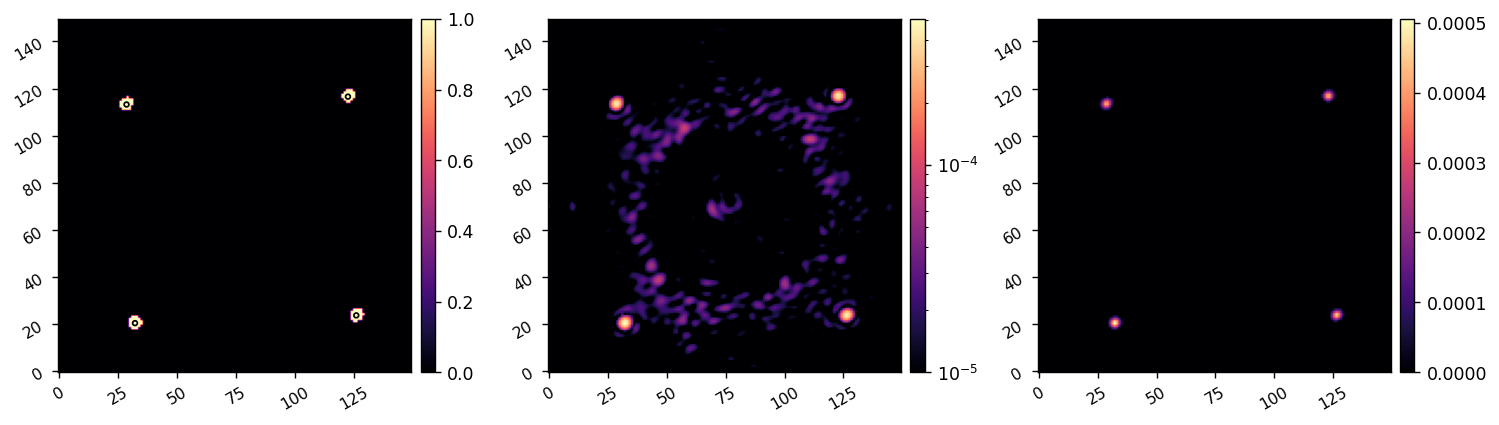

Angle:  87.88920264518293
Measured center in X:  77.32890487238514
Measured center in Y:  68.44072577906996
Required shift in X:  -2.0
Required shift in Y:  7.0


In [59]:
reload(scoobi.utils)

xshift,yshift,angle = scoobi.utils.measure_center_and_angle(waffle_im, I.psf_pixelscale_lamD, im_thresh=5e-5, r_thresh=16)

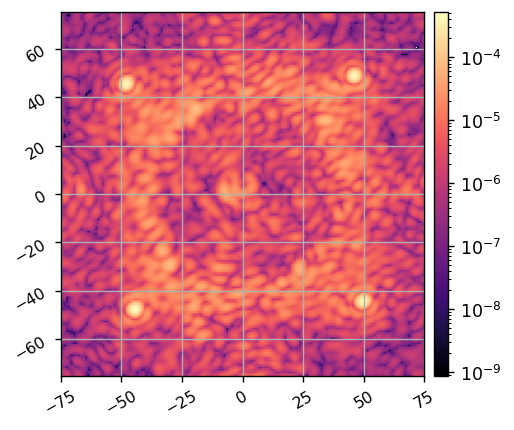

In [60]:
I.Nframes = 10
I.npsf = 150
I.x_shift = xshift
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()
imshow1(coro_im, lognorm=True, pxscl=1, grid=True)

In [49]:
I.zero_dm()

# Choose modes and probes for iEFC

In [61]:
reload(lina.utils)

iwa = 2.5
owa = 12
rotation = 0
control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, iwa, owa, edge=iwa, rotation=rotation)

Set the ZWO exposure time to 5.00e-04s
3.940871628884034e-06


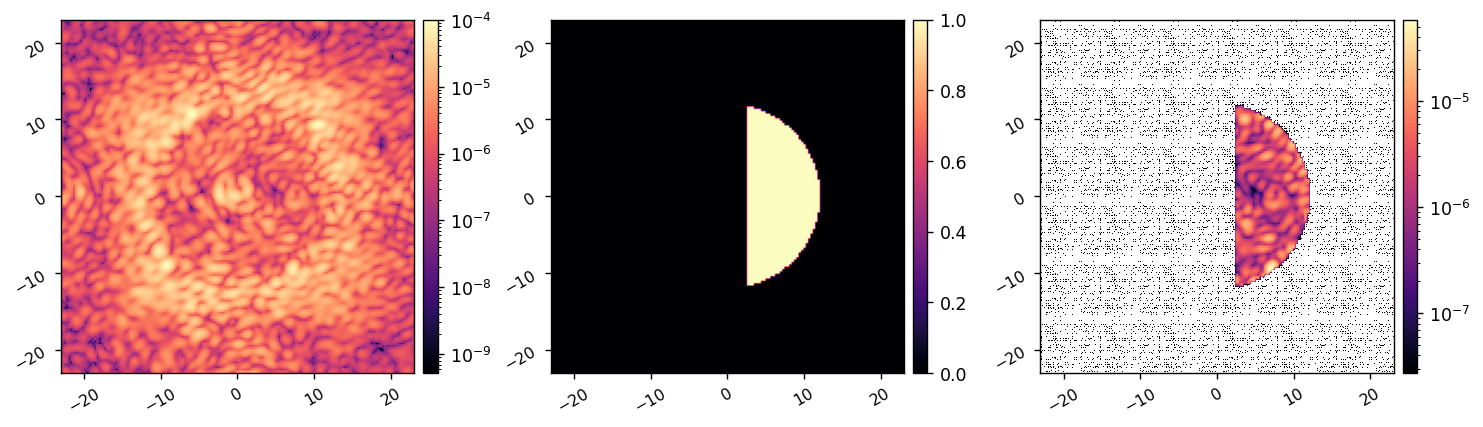

Saved data to:  data/20241017_ref_coro_im.fits


In [72]:
I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
I.set_zwo_exp_time(0.0005, client0)

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamD)
lina.utils.save_fits(f'data/{today}_ref_coro_im.fits', ref_coro_im)

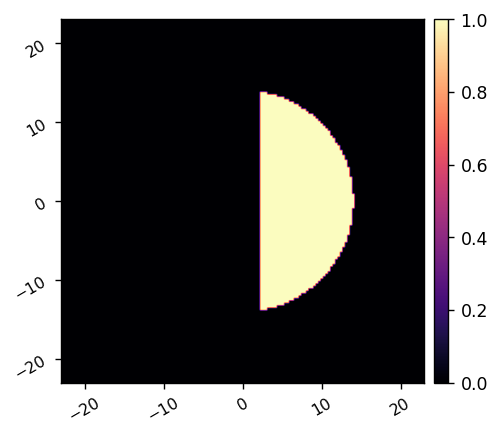

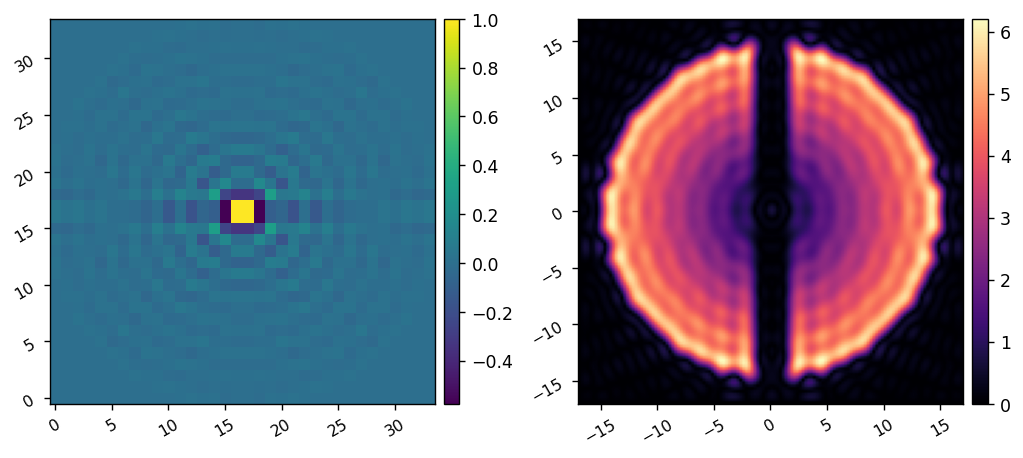

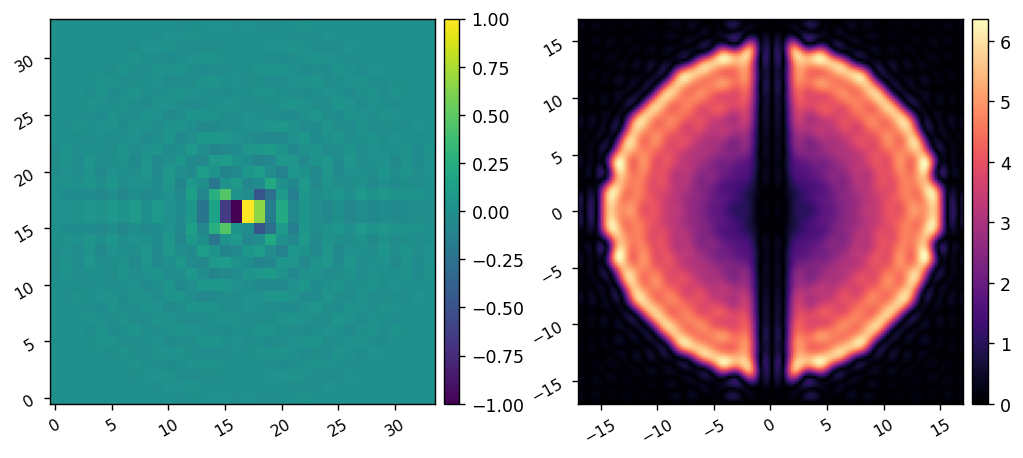

In [71]:
reload(lina.utils)
probe_iwa = 2
probe_owa = 14
probe_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, edge=probe_iwa)
imshow1(probe_mask, pxscl=I.psf_pixelscale_lamD)
probe_modes = lina.utils.create_fourier_probes(xp.array(I.dm_mask), I.npsf, I.psf_pixelscale_lamD, probe_iwa, probe_owa, rotation=0,
                                               fourier_sampling=0.75, 
                                                shifts=None, 
                                                nprobes=2,
                                                use_weighting=True, 
                                                plot=True,
                                               )
# for i in range(probe_modes.shape[0]):
#     probe_modes[i] = xp.rot90(probe_modes[i])

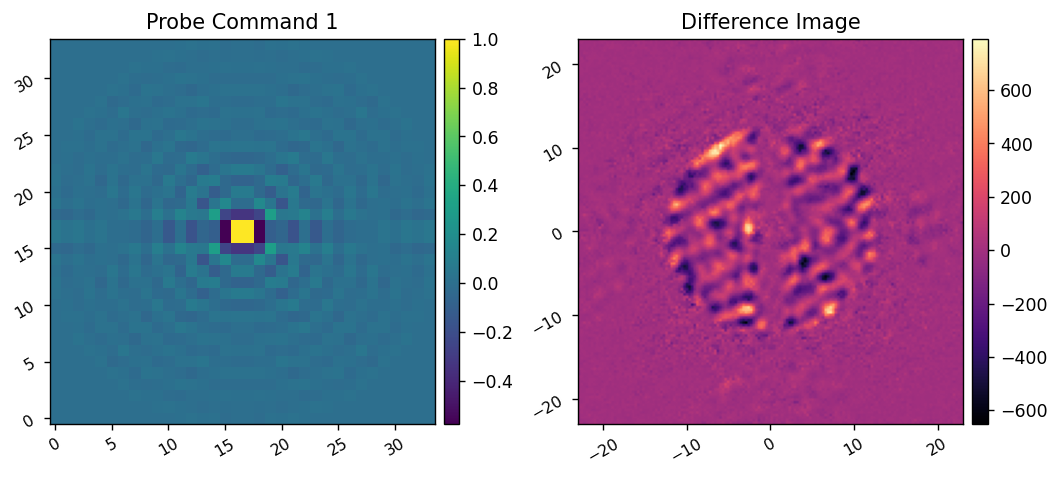

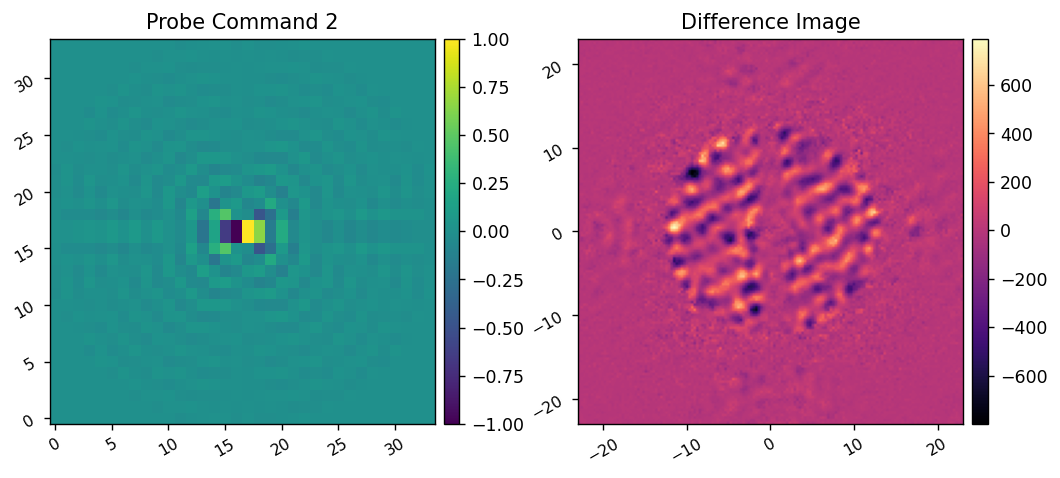

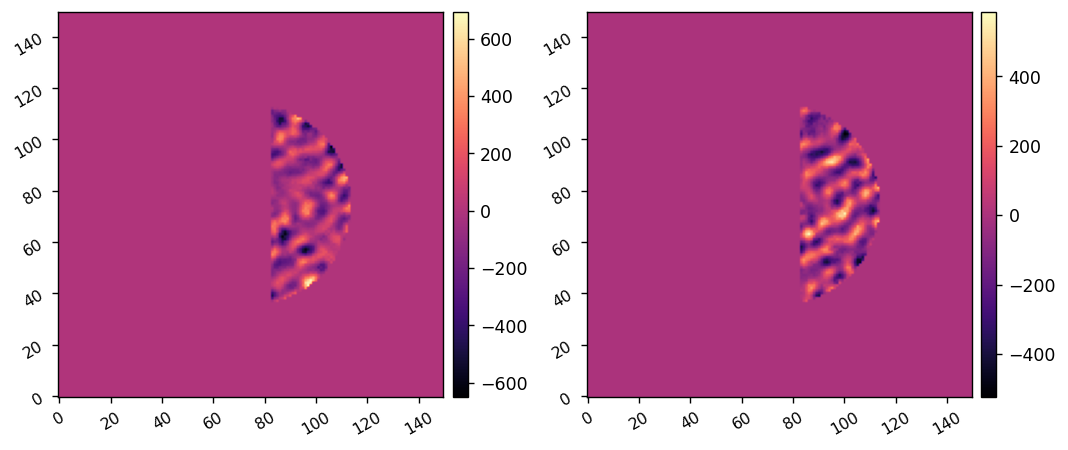

In [74]:
reload(lina.iefc)

I.NSCICAM = 10
I.subtract_dark = False
I.return_ni = True
diff_ims = lina.iefc.take_measurement(I, probe_modes, 5e-9, plot=True)
diff_ims *= control_mask
imshow2(diff_ims[0], diff_ims[1])
# imshow3(diff_ims[0], diff_ims[1], diff_ims[2])

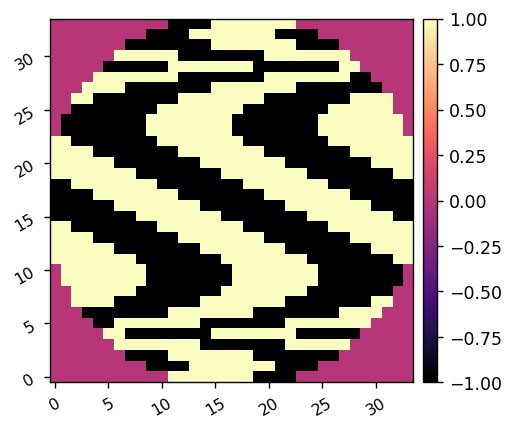

In [75]:
reload(lina.utils)
calib_modes = lina.utils.create_hadamard_modes(xp.array(I.dm_mask))
imshow1(calib_modes[8])


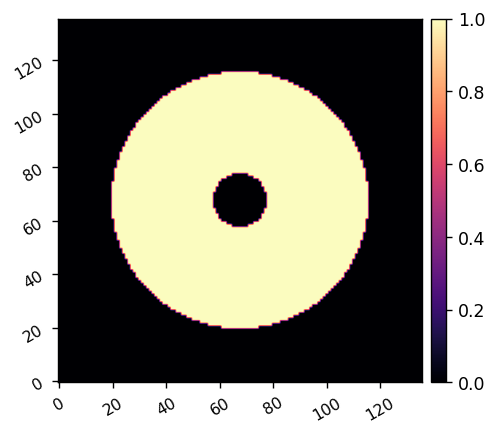

(1024,)
[1.19805206 1.93675952 1.50992211 1.58041594]


In [76]:
reload(scoobi.utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:I.Nact**2].reshape(I.Nact, I.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(scoobi.utils.pad_or_crop(had_mode, I.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-I.Nact*oversamp//2, I.Nact*oversamp//2-1, I.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>2.5)*(r<12)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]**2))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/6))
    # scale_factors.append((biggest_sum/sum_vals[i])**(1/2))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

scale_thresh = 4
scale_factors[scale_factors>scale_thresh] = scale_thresh
print(scale_factors[8:12])

In [110]:
1.1**(1/4)

1.0241136890844451

In [68]:
I.zero_dm()

In [77]:
reload(lina.iefc)
I.zero_dm()

probe_amp = 5e-9
calib_amp = 2.5e-9

I.NSCICAM = 10
I.return_ni = True
I.subtract_dark = False
I.dm_delay = I.texp * 3
print(I.dm_delay)

time.sleep(2)
response_matrix, response_cube = lina.iefc.calibrate(I, control_mask, 
                                                     probe_amp, probe_modes, 
                                                     calib_amp, calib_modes, scale_factors=scale_factors, 
                                                    #  calib_amp, calib_modes[100:110], 
                                                    #  scale_factors=scale_factors[100:110], 
                                                    #  calib_amp, calib_modes[8:12], 
                                                    #  scale_factors=scale_factors[8:12], 
                                                     return_all=True,
                                                     )

0.0015
Calibrating iEFC...
	Calibrated mode 1024/1024 in 626.949s
Calibration complete.


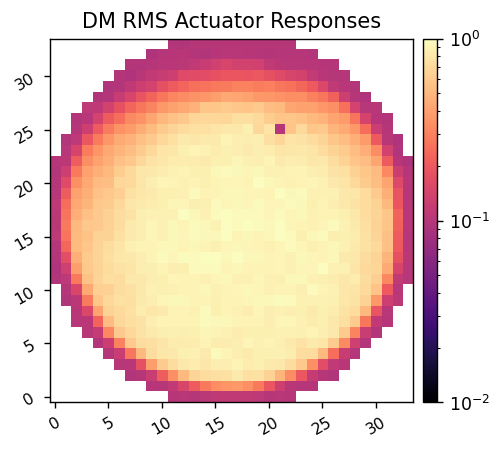

In [78]:
dm_response_map = xp.sqrt(xp.mean(xp.square(response_matrix.dot(calib_modes.reshape(1024, -1))), axis=0))
dm_response_map = dm_response_map.reshape(I.Nact,I.Nact) / xp.max(dm_response_map)
imshow1(dm_response_map, 'DM RMS Actuator Responses', lognorm=True, vmin=1e-2)

In [79]:
lina.utils.save_fits(f'data/{today}_iefc_hadamard_jac.fits', response_matrix)
lina.utils.save_fits(f'data/{today}_iefc_hadamard_jac_cube.fits', response_cube)
lina.utils.save_fits(f'data/{today}_iefc_probes.fits', probe_modes)

# lina.utils.save_fits('../data/iefc_fourier_jac_20240806.fits', response_matrix)
# lina.utils.save_fits('../data/iefc_fourier_jac_cube_20240806.fits', response_cube)

Saved data to:  data/20241017_iefc_hadamard_jac.fits
Saved data to:  data/20241017_iefc_hadamard_jac_cube.fits
Saved data to:  data/20241017_iefc_probes.fits


In [80]:
I.zero_dm()
all_ims = []
all_commands = []

In [79]:
I.set_dm(all_commands[-1])

0.06
Running iEFC...
	Closed-loop iteration 13 / 15
(1024, 1156) (1024,)


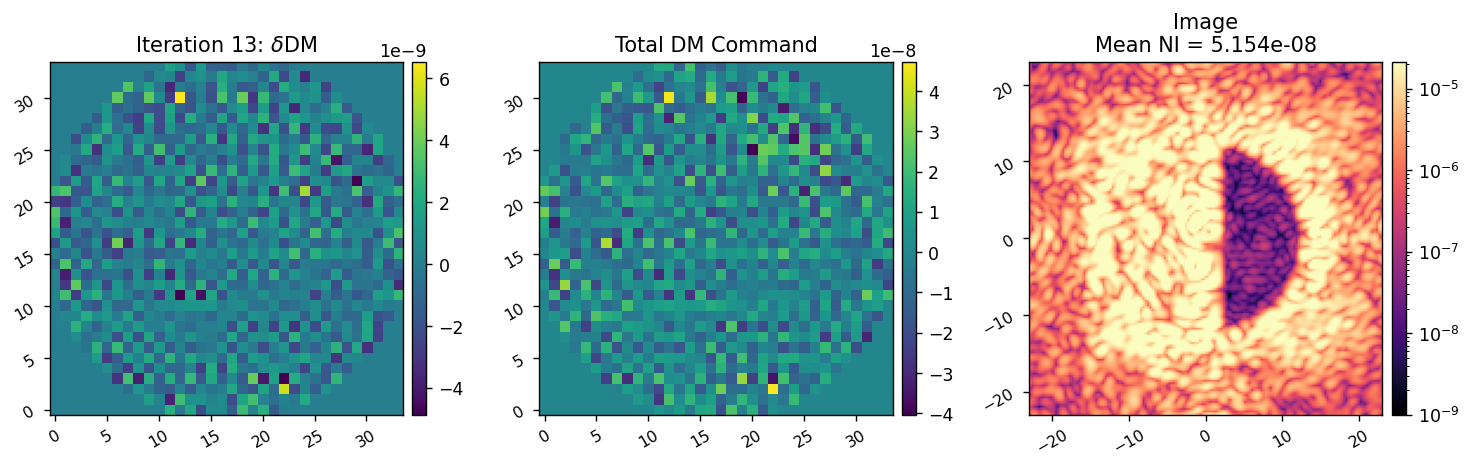

	Closed-loop iteration 14 / 15
(1024, 1156) (1024,)


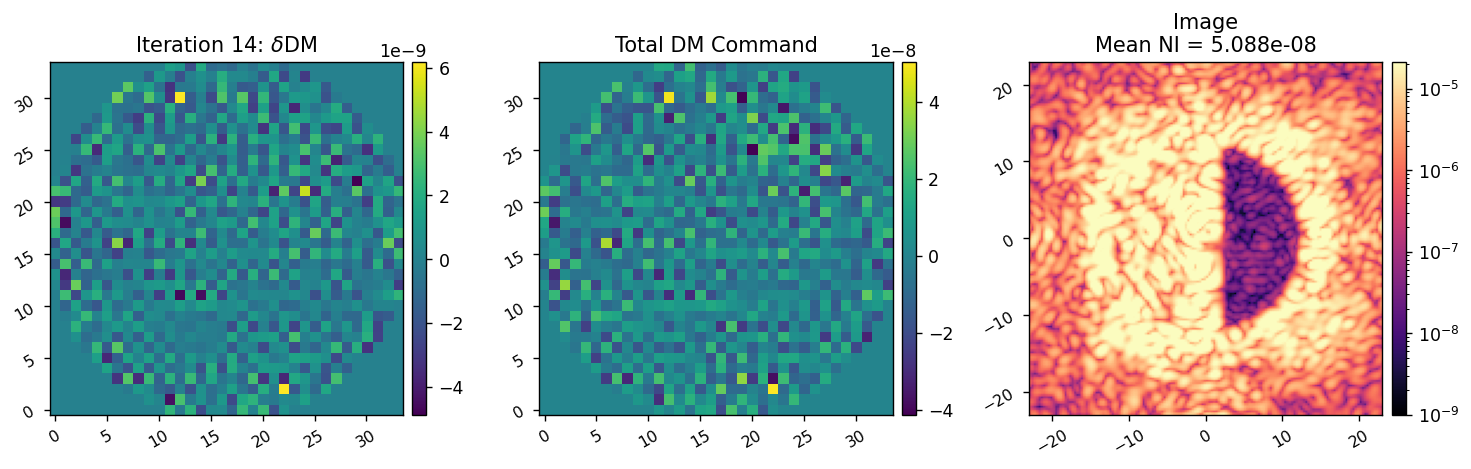

	Closed-loop iteration 15 / 15
(1024, 1156) (1024,)


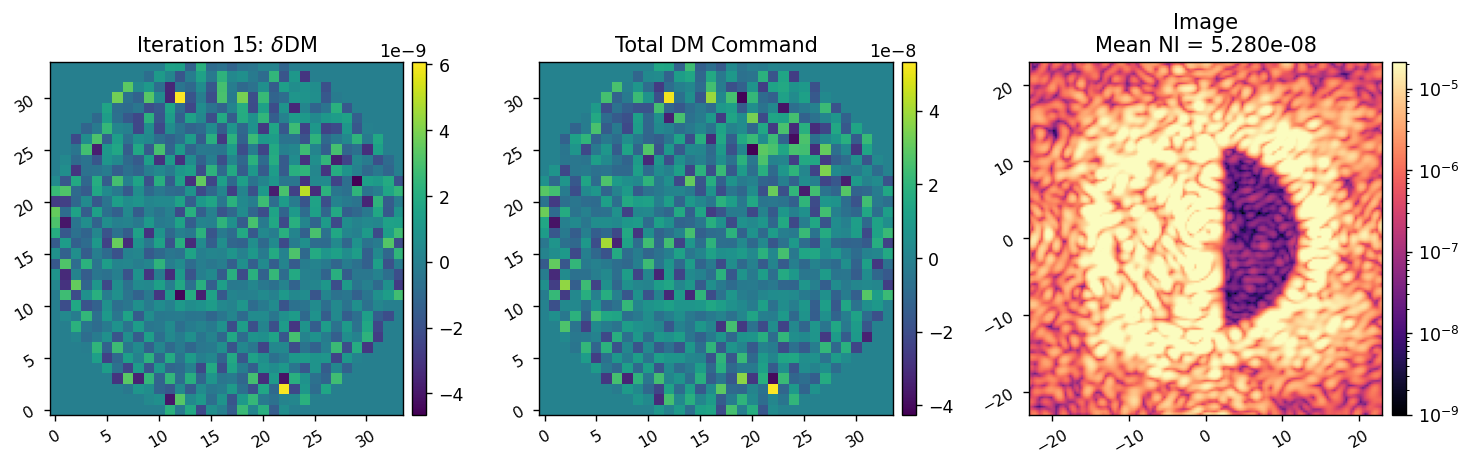

Closed loop for given control matrix completed in 13.375s.


In [90]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(response_matrix, -2.5)
cm = lina.utils.beta_reg(response_matrix, -3.5)
# cm = lina.utils.beta_reg(response_matrix, -5)

probe_amp = 5e-9
# probe_amp = 4e-9
probe_amp = 3e-9
# probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
# probe_amp = 1e-9

I.NSCICAM = 20
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims,
                                        all_commands=all_commands,
                                        )

In [83]:
I.set_zwo_exp_time(0.02, client0, delay=1)
I.set_zwo_gain(120, client0)
I.NSCICAM = 10

Set the ZWO exposure time to 2.00e-02s
Set the ZWO gain setting to 120.0


In [84]:
reload(scoobi)
scoobi.move_block_in(client0)

In [86]:
reload(scoobi)
scoobi.move_block_out(client0)

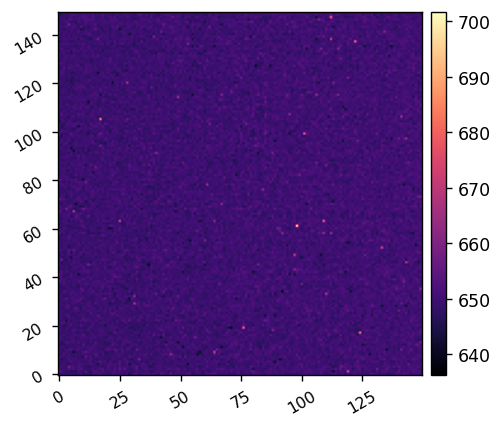

In [85]:
I.NSCICAM = 100
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

5.2591670277044035e-08


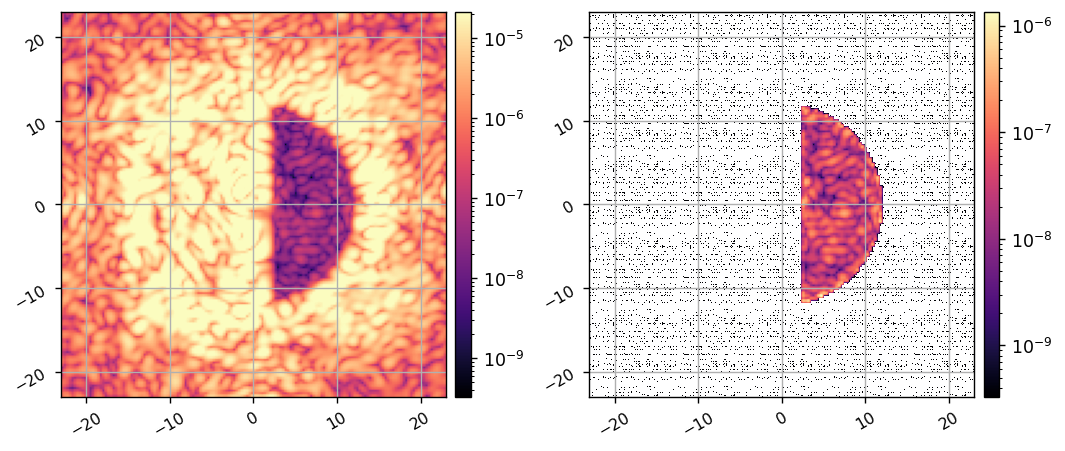

In [91]:
I.NSCICAM = 20
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im, grid=True, lognorm=True, pxscl=I.psf_pixelscale_lamD)

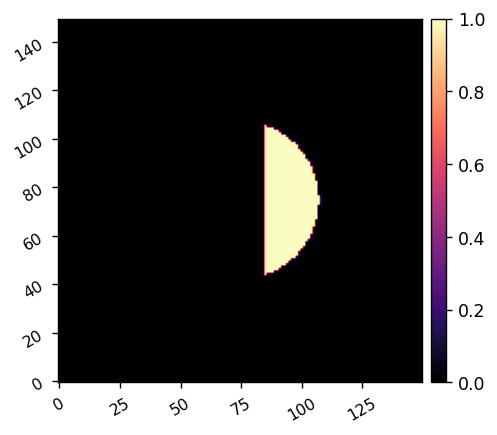

In [92]:
new_iwa = 3
new_owa = 10
new_control_mask = lina.utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamD, new_iwa, new_owa, edge=new_iwa, rotation=rotation)
imshow1(new_control_mask)

In [93]:
new_response_matrix = response_cube[:, :, new_control_mask.ravel()].reshape(1024, -1).T
new_response_matrix.shape

(2044, 1024)

0.06
Running iEFC...
	Closed-loop iteration 28 / 30
(1024, 1156) (1024,)


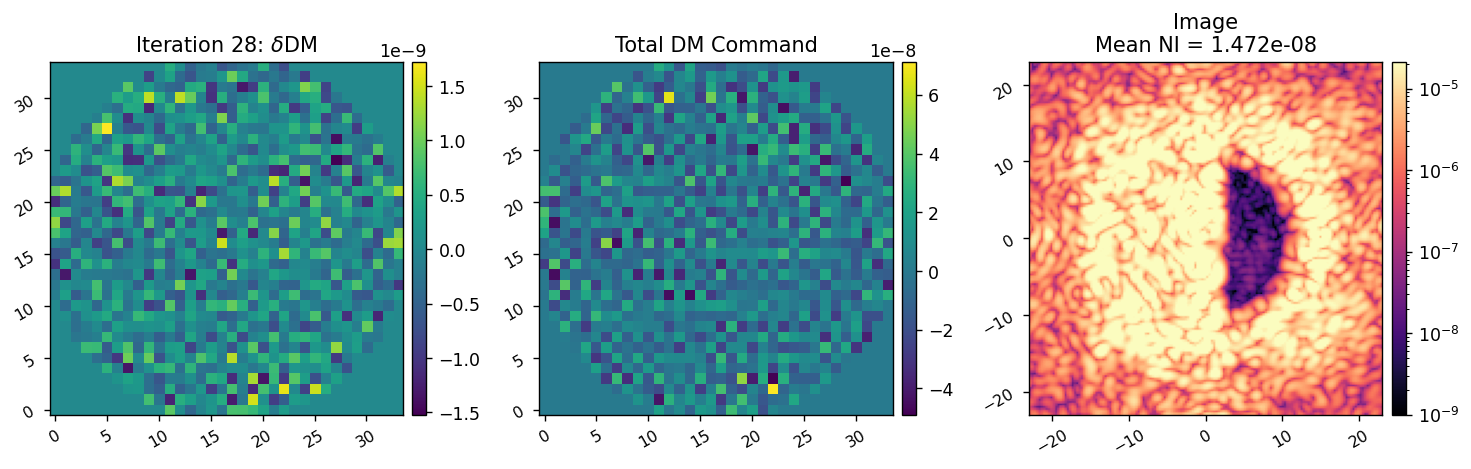

	Closed-loop iteration 29 / 30
(1024, 1156) (1024,)


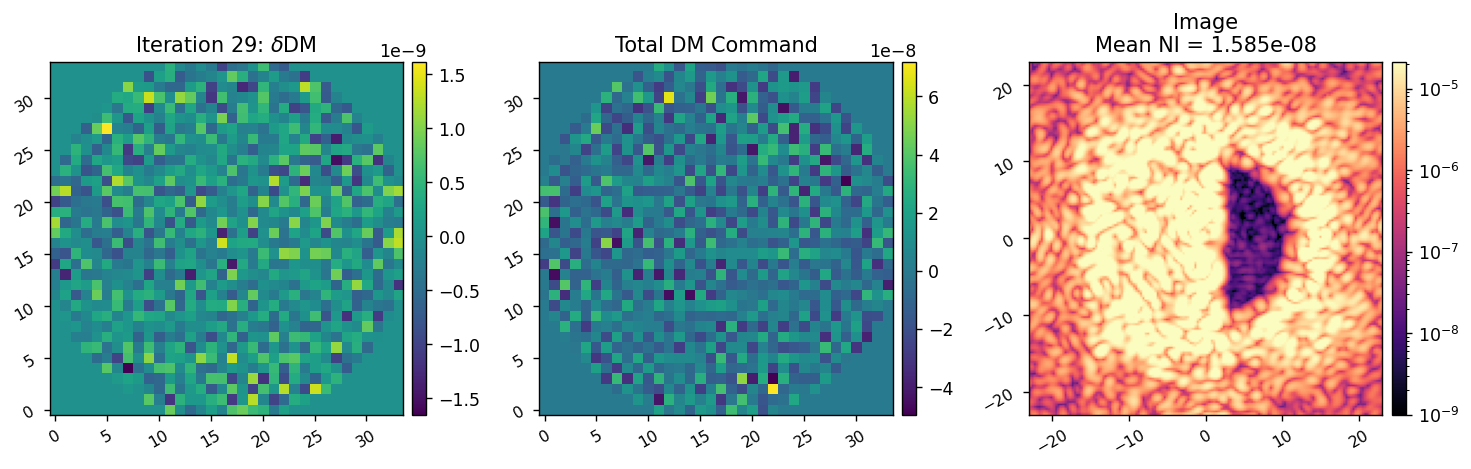

	Closed-loop iteration 30 / 30
(1024, 1156) (1024,)


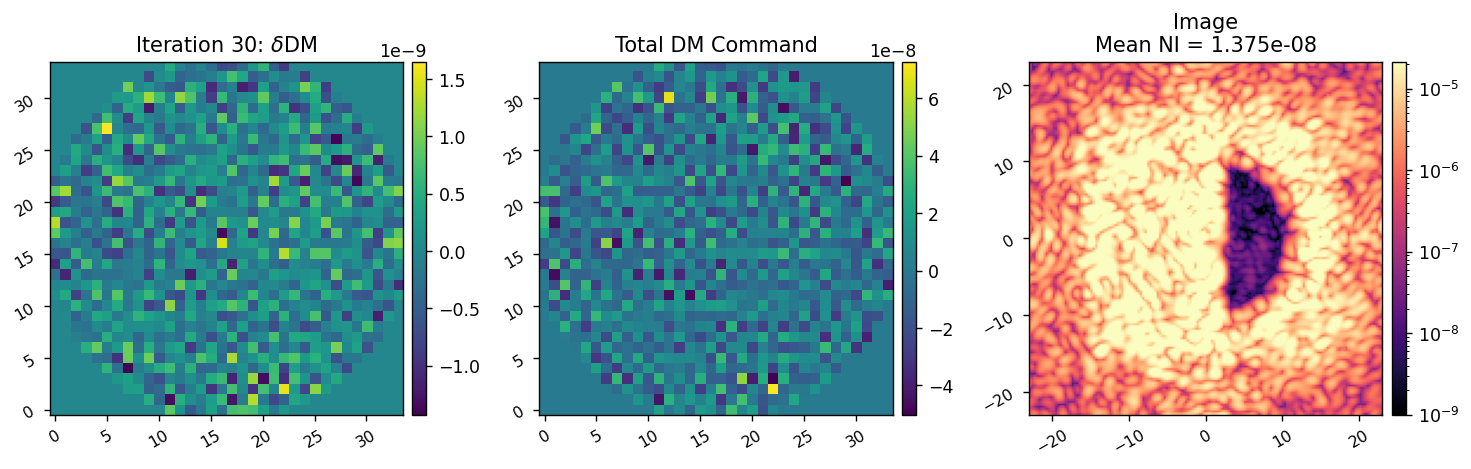

Closed loop for given control matrix completed in 25.475s.


In [100]:
reload(lina.utils)
reload(lina.iefc)

cm = lina.utils.beta_reg(new_response_matrix, -2.5)
# cm = lina.utils.beta_reg(new_response_matrix, -3.5)
# cm = lina.utils.beta_reg(new_response_matrix, -5)

probe_amp = 5e-9
# probe_amp = 4e-9
probe_amp = 2.5e-9
# probe_amp = 2e-9
probe_amp = 1.5e-9
probe_amp = 1e-9
probe_amp = 0.75e-9
# probe_amp = 0.5e-9

I.NSCICAM = 50
I.return_ni = True
I.dm_delay = 3*I.texp
print(I.dm_delay)

all_ims, all_commands = lina.iefc.run(I,
                                        cm,
                                        probe_modes, probe_amp, 
                                        calib_modes,
                                        new_control_mask,
                                        num_iterations=3,
                                        loop_gain=0.5, 
                                        leakage=0.0,
                                        plot_current=True,
                                        plot_all=True,
                                        plot_probes=False,
                                        plot_radial_contrast=False,
                                        all_ims=all_ims, 
                                        all_commands=all_commands,
                                        )

In [157]:
lina.utils.save_fits(f'data/{today}_iefc_hadamard_ims.fits', xp.array(all_ims))
lina.utils.save_fits(f'data/{today}_iefc_hadamard_commands.fits', xp.array(all_commands))
lina.utils.save_fits(f'data/{today}_iefc_control_mask_1.fits', control_mask.astype(int))
lina.utils.save_fits(f'data/{today}_iefc_control_mask_2.fits', new_control_mask.astype(int))


Saved data to:  data/20240910_iefc_hadamard_ims.fits
Saved data to:  data/20240910_iefc_hadamard_commands.fits
Saved data to:  data/20240910_iefc_control_mask_1.fits
Saved data to:  data/20240910_iefc_control_mask_2.fits


In [130]:
I.set_zwo_exp_time(0.05, client0, delay=1)
I.set_zwo_gain(120, client0)
I.Nframes = 10

Set the ZWO exposure time to 5.00e-02s
Set the ZWO gain setting to 120.0


In [131]:
reload(scoobi)
scoobi.move_block_in(client0)

In [133]:
reload(scoobi)
scoobi.move_block_out(client0)

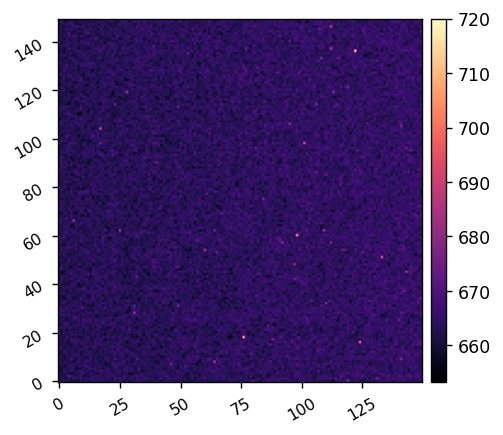

In [132]:
I.NSCICAM = 50
I.subtract_dark = False
I.return_ni = False
dark_frame = I.snap()
imshow1(dark_frame)

I.df = copy.copy(dark_frame)

1.4489141142136657e-08


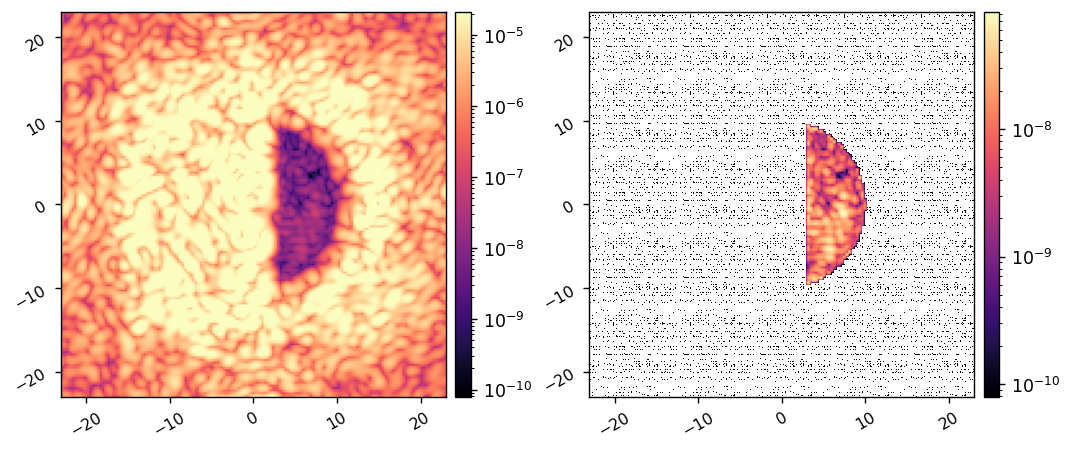

In [99]:
I.NSCICAM = 50
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[new_control_mask]))
imshow2(coro_im, new_control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamD)

# Monitor the dark hole

In [103]:
reload(scoobi)
from pathlib import Path

duration = 1800
# duration = 10
I.NSCICAM = 50

# time.sleep(5)
scoobi.stream_scicam(I, 
                     duration=duration, 
                     control_mask=new_control_mask, 
                    #  plot=True, 
                    #  clear=True, 
                     save_data_to=Path(f'camsci-streams/{today}_ims_with_llowfsc.fits'),
                     )

Saved data to:  camsci-streams/20241017_ims_with_llowfsc.fits


In [149]:
modal_matrix = had_modes.reshape(1024, -1)

In [148]:
camsci_data = lina.utils.load_fits(f'camsci-streams/{today}_ims_without_llowfsc.fits')
camsci_data.shape

(1794, 150, 150)

In [169]:
I.zero_dm()

# Run iEFC in an automatic loop

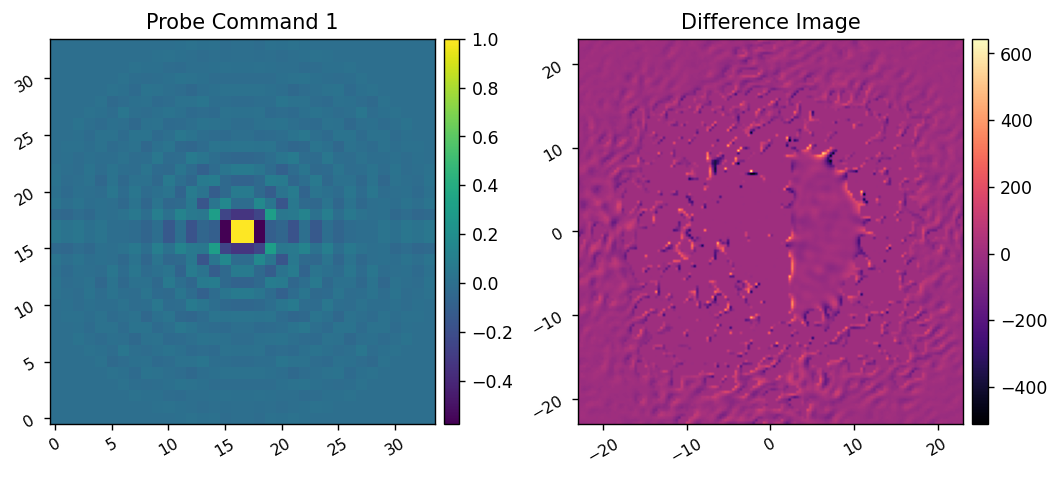

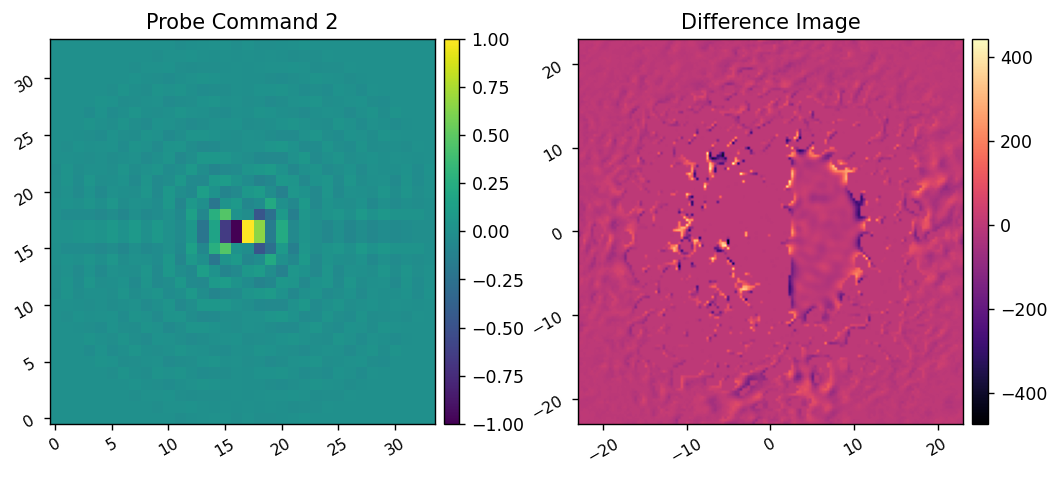

(1024, 2044) (2044,)


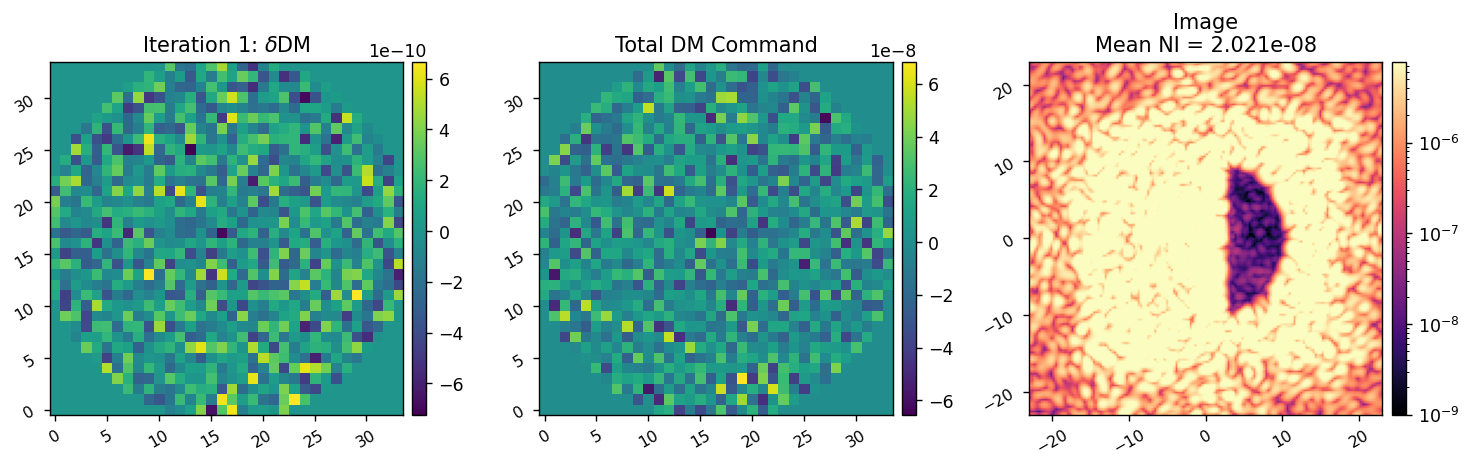

In [172]:
reload(lina.iefc)
probe_amp = 1e-9
modal_matrix = had_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

lina.iefc.run_iteration(I, probe_modes, probe_amp, cm, modal_matrix, new_control_mask, gain=0.5, plot=True, plot_probes=True)

In [181]:
reload(lina.iefc)
iefc_freq = 1/10
I.dm_delay = 2*I.texp

probe_amp = 1e-9
modal_matrix = had_modes.reshape(1024, -1)
cm = lina.utils.beta_reg(new_response_matrix, -2.5)

args = [I, probe_modes, probe_amp, cm, modal_matrix, new_control_mask]
kwargs = {
    'gain':0.5,
    'plot':True,
    # 'plot_probes':True,
    # 'clear':False, 
}

iefc_process = lina.utils.Process(iefc_freq, 
                                       lina.iefc.run_iteration, 
                                       args, # the args
                                       kwargs, # the kwargs
                                       )

(1024, 2044) (2044,)


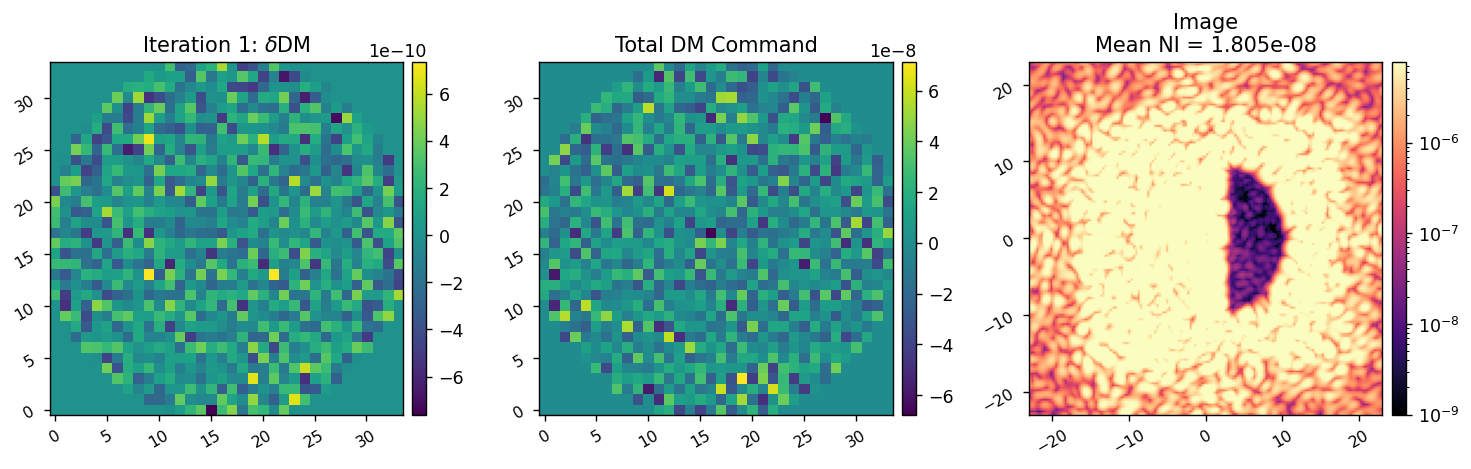

In [182]:
iefc_process.start()

(1024, 2044) (2044,)


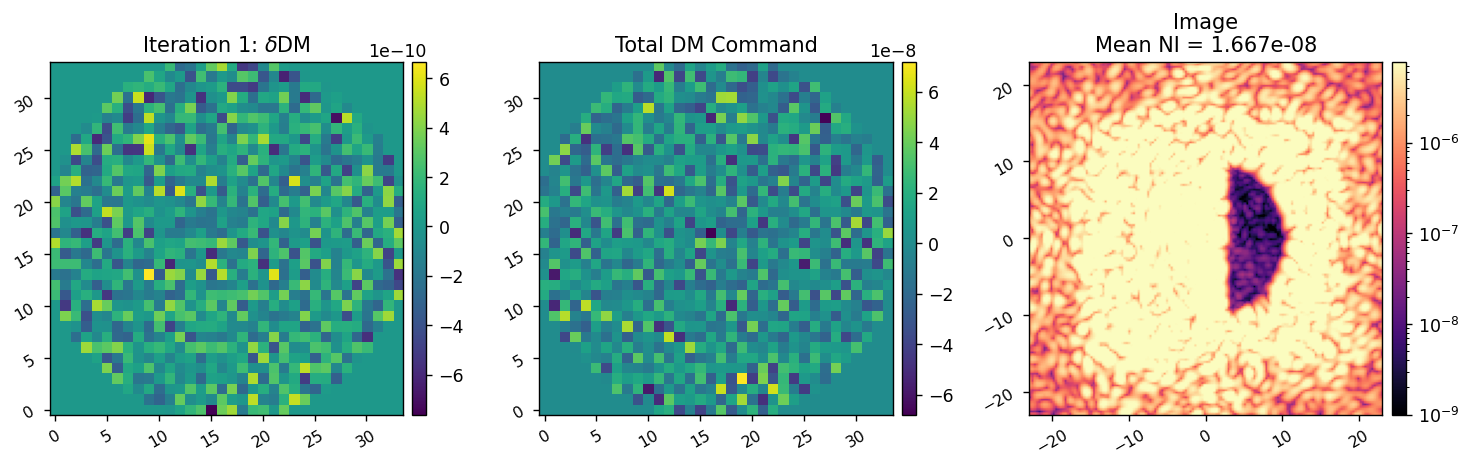

In [183]:
iefc_process.cancel()

In [104]:
I.zero_dm()

In [105]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s
